# Import Libraries

In [54]:
import pandas as pd
import arff
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
import scipy.stats as ss
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'dateutil.rrule'

# Preprocessing and Creation of DF

In [39]:


data_freq = arff.load('/workspaces/coding_challenge/df/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('/workspaces/coding_challenge/df/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

# change dtypes of ID to int 
df_freq['IDpol'] = df_freq['IDpol'].astype(int)
# also I set the ID as index
df_freq.set_index("IDpol", inplace=True)

# same for df_sev
df_sev['IDpol'] = df_sev['IDpol'].astype(int)

# check on missing values in both datasets
df_freq.isnull().sum() # --> None 
df_sev.isnull().sum() # --> None

#I want one row per ID and the sum of all claim amounts for that ID
df_sev = df_sev.groupby("IDpol").sum()
#Now I join the two datasets
df = df_freq.join(df_sev, how="left")

# I assume for the rest of the data that now row in df_sev means claim amount = 0
df["ClaimAmount"] = df["ClaimAmount"].fillna(0)

# And create the new dependent variable ClaimAmount/Exposure
df["ClaimAmountDivByExposure"] = df["ClaimAmount"]/df["Exposure"]

# Summary statistics

In [34]:
# get rows with claim amount not null 
df[df.ClaimAmount.notnull()]
# check if there are claim amounts for claim number 0
df[(df.ClaimNb == 0) & (df.ClaimAmount != 0.0)] # --> 0 rows

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountDivByExposure
IDpol,,,,,,,,,,,,,


In [55]:
# get summary statistics for the dataset (continuous variables only)
df.describe()

,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmountDivByExposure
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05
mean,6.454631,7.044265,45.499122,59.761502,1792.422405,3.832608e+02
std,2.050906,5.666232,14.137444,15.636658,3958.646564,3.682070e+04
min,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00
25%,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00
50%,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00
75%,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00
max,15.000000,100.000000,100.000000,230.000000,27000.000000,1.852455e+07


In [36]:
# get summary statistics for the dataset (categorical variables only)
df.describe(include="object")

,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,'C','B12',Regular,'R24'
freq,191880,166024,345877,160601


# Plots

### Continous variables

In [40]:
# plot the distributions of all continuous variables with a large plot size
fig = plt.figure(figsize = (25,20))
ax = fig.gca()
df.hist(ax = ax, bins=40)
plt.show()

ModuleNotFoundError: No module named 'dateutil.rrule'

- We have a massive skew for some of our variables (especially ClaimAmount & ClaimNb where we witness more or equal to 95% for only one value)
- Most of the distributions appear to be skewed in the right direction --> Model should be capable of handling such a skewed distribution

In [ ]:
# how much of ClaimAmount is zero? 
print(df[df.ClaimAmount == 0].shape[0] / df.shape[0]) # 96% !!
# how much of ClaimNb is zero?
print(df[df.ClaimNb == 0].shape[0] / df.shape[0]) # Almost 95 % 
# how much of BonusMalus is 50?
print(df[df.BonusMalus == 50].shape[0] / df.shape[0]) # Almost 57%  
# how much of Exposure is 1?    
print(df[df.Exposure == 1].shape[0] / df.shape[0]) # almost 35 % 

#how much of our target variable ClaimAmountDivByExposure is zero? 
print(df[df.ClaimAmountDivByExposure == 0.0].shape[0] / df.shape[0]) # almost 96% 
# --> this could be a problem... 

0.9632101449382239
0.9497649750078538
0.5665909060740724
0.2479672218674273
0.9632101449382239


### Categorial variables

In [43]:
# plot the distributions of all categorial variables
df['Area'].value_counts().plot(kind='bar')

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

<Axes: xlabel='VehBrand'>

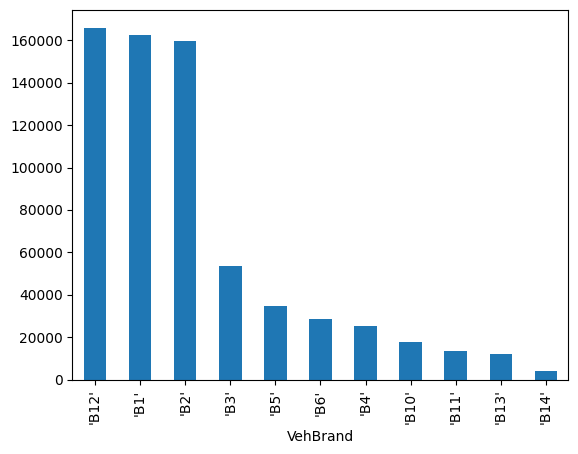

In [ ]:
df['VehBrand'].value_counts().plot(kind='bar')

- Dominance of Vehicle Brands B12, B1 and B2 

<Axes: xlabel='VehGas'>

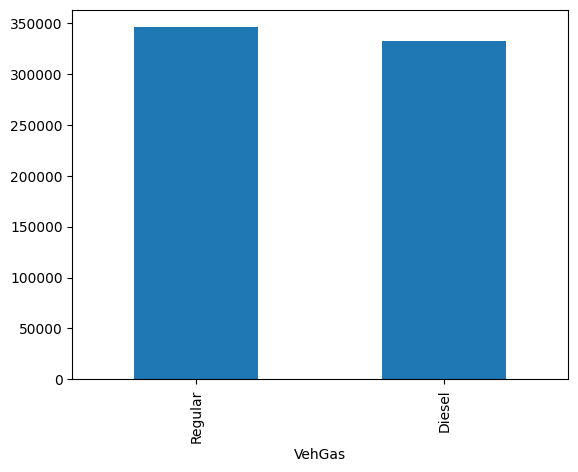

In [ ]:
df['VehGas'].value_counts().plot(kind='bar')

- VehGas appears to be rather even

<Axes: xlabel='Region'>

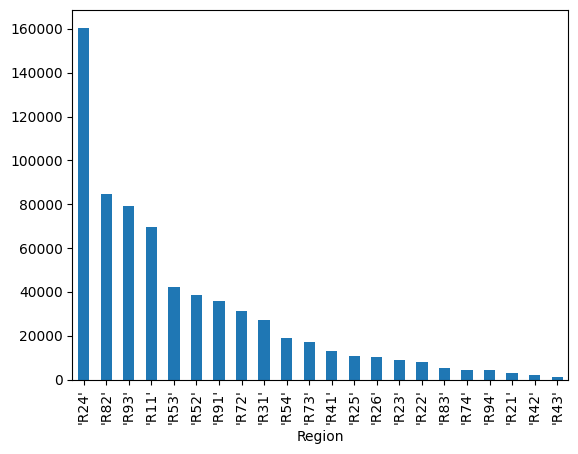

In [ ]:
df['Region'].value_counts().plot(kind='bar')

- R24 appears to dominate the regions. Why is this the case? Could be the capital region or another areas with higher density of population --> Check correlation

### Correlations of variables

### Continous variables

<Axes: >

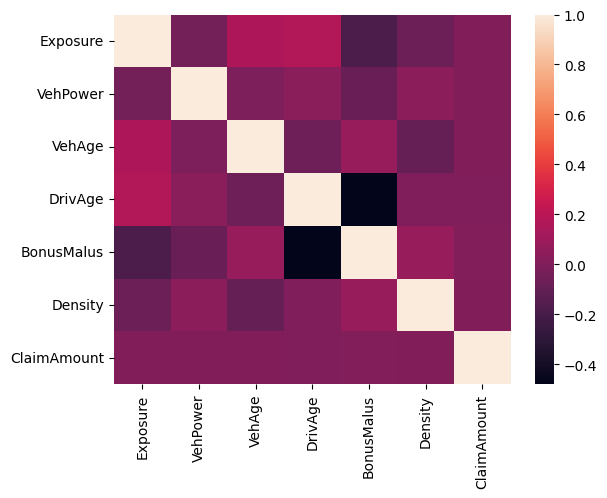

In [ ]:
# Plot of correlations between all continuous variables
import seaborn as sns
# get only variables with numeric values and exlude ClaimAmountDivByExposure
df_num = df.drop(columns=["ClaimAmountDivByExposure", "ClaimNb"])._get_numeric_data()
corr = df_num.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
corr

,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount
Exposure,1.000000,-0.045259,0.151554,0.171873,-0.183018,-0.071085,0.002244
VehPower,-0.045259,1.000000,-0.006001,0.030108,-0.075895,0.042901,0.001275
VehAge,0.151554,-0.006001,1.000000,-0.059213,0.079923,-0.090428,0.002321
DrivAge,0.171873,0.030108,-0.059213,1.000000,-0.479966,-0.004700,-0.003663
BonusMalus,-0.183018,-0.075895,0.079923,-0.479966,1.000000,0.077717,0.009956
Density,-0.071085,0.042901,-0.090428,-0.004700,0.077717,1.000000,-0.000056
ClaimAmount,0.002244,0.001275,0.002321,-0.003663,0.009956,-0.000056,1.000000


- Stronger negative correlation between drivers age and bonus malus --> the higher the age the lower the BonusMalus score, which makes sense because the older I am the more likely I am to have a bonus (researched: score under 100)
- Also a stronger (compared to the others) negative correlation between BonusMalus and Exposure --> The longer I am "exposed", which means I have an active insurance, the more likely I am to have a bonus 

### Categorial variables
As I'm not just interested in the connection/correlation between all my already categorial features but also the continous ones, I'll put them into bins to mimick categorial traits. Afterwards Cramers V is calculated between them.

In [ ]:
# get Cramers V for all categorical and binned continous variables
df_binned = df.copy()
df_binned["VehPower"] = pd.cut(df["VehPower"], 5)
df_binned["VehAge"] = pd.cut(df["VehAge"], 5)
df_binned["DrivAge"] = pd.cut(df["DrivAge"], 5)
df_binned["Density"] = pd.cut(df["Density"], 5)
df_binned["BonusMalus"] = pd.cut(df["BonusMalus"], 5)

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

categorical_vars = ["Area", "VehBrand", "VehGas", "Region", "VehPower", "VehAge", "DrivAge", "Density", "BonusMalus"]
cramers_v_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)
for var1 in categorical_vars:
    for var2 in categorical_vars:
        # print(f"Finished cramers_v for {var1} and {var2}.") # for those that are interested in the progress of the calculations
        cramers_v_matrix.loc[var1, var2] = cramers_v(df[var1], df[var2])

cramers_v_matrix   

Finished cramers_v for Area and Area.
Finished cramers_v for Area and VehBrand.
Finished cramers_v for Area and VehGas.
Finished cramers_v for Area and Region.
Finished cramers_v for Area and VehPower.
Finished cramers_v for Area and VehAge.
Finished cramers_v for Area and DrivAge.
Finished cramers_v for Area and Density.
Finished cramers_v for Area and BonusMalus.
Finished cramers_v for VehBrand and Area.
Finished cramers_v for VehBrand and VehBrand.
Finished cramers_v for VehBrand and VehGas.
Finished cramers_v for VehBrand and Region.
Finished cramers_v for VehBrand and VehPower.
Finished cramers_v for VehBrand and VehAge.
Finished cramers_v for VehBrand and DrivAge.
Finished cramers_v for VehBrand and Density.
Finished cramers_v for VehBrand and BonusMalus.
Finished cramers_v for VehGas and Area.
Finished cramers_v for VehGas and VehBrand.
Finished cramers_v for VehGas and VehGas.
Finished cramers_v for VehGas and Region.
Finished cramers_v for VehGas and VehPower.
Finished cramers

,Area,VehBrand,VehGas,Region,VehPower,VehAge,DrivAge,Density,BonusMalus
Area,1.0,0.073171,0.131411,0.319425,0.03956,0.056763,0.033491,0.997062,0.066813
VehBrand,0.073171,1.0,0.116451,0.129941,0.157503,0.17197,0.052935,0.160174,0.03323
VehGas,0.131411,0.116451,0.999997,0.094239,0.318712,0.147544,0.126357,0.200454,0.062148
Region,0.319425,0.129941,0.094239,1.0,0.043342,0.062862,0.033897,0.681205,0.034423
VehPower,0.03956,0.157503,0.318712,0.043342,1.0,0.073697,0.039663,0.117997,0.032264
VehAge,0.056763,0.17197,0.147544,0.062862,0.073697,1.0,0.017766,0.036415,0.012523
DrivAge,0.033491,0.052935,0.126357,0.033897,0.039663,0.017766,1.0,0.054378,0.091686
Density,0.997062,0.160174,0.200454,0.681205,0.117997,0.036415,0.054378,1.0,0.074923
BonusMalus,0.066813,0.03323,0.062148,0.034423,0.032264,0.012523,0.091686,0.074923,1.0


Very strong correlation (>0.25): 
- Region and area
- Vehicle power and vehicle gas 
- Density and area --> Quick research gave the result, that area code might have been created via density... I'll exclude area and stick to density as both variables are more or less explaining the same variance. 
- Region and density

Strong correlation (>0.15): 
- vehicle power and brand 
- Density and vehicle brand 
- Density and vehicle gas 

All other variables appear to be moderately or weakly connected...

In [44]:
df.drop('Area', axis=1, inplace=True) 

# Feature creation

In [46]:
# Drop ClaimNb, ClaimAmount and Exposure as they appear to be part of what we want to model here!
df.drop(columns=["ClaimNb", "ClaimAmount", "Exposure"], inplace=True) 

In [48]:
# One hot encode all categorical variables
df = pd.get_dummies(df)

# Model Selection and Training

Our target variable ist continous (ClaimAmount/Exposure), thus we're modelling a regression problem. 
Two loss functions to optimize for in such a scenario are: 
- Mean Absolute Error --> All prediction errors are weighted equally 
- Root Mean Square Error --> Bigger prediction errors are weighted much more thus our model becomes much more sensitive to the distribution of our data 
... 
As I've done no handling of outliers whatsoever I'll go with MAE. 

On optimization step later on could be to think about how to handle outliers (maybe cut them off) and to then maybe change our loss function to RMSE. 
Also a much deeper investigation of much more specialized loss functions could be done to find the optimal solution. 


As we've seen our dataset has some features that correlate with each other, which might get a problem for certain models like a simple linear regression model for example. 
Thus a model has to be chosen, that can work with such feature correlations. Also I'm no insurance data domain expert, thus I'd prefer some modelling approach that scores good 
results without me having a strong backround in the domain! Also the model has to work with heavily skewed data...

In [49]:
y = df['ClaimAmountDivByExposure']
X = df.drop(columns=['ClaimAmountDivByExposure'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
param_dist = { 
    'max_depth': stats.randint(3, 10),
    'min_child_weight': stats.uniform(0.0, 1),
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.5, 0.5),
    'n_estimators':stats.randint(50, 200), 
    'colsample_bytree': stats.uniform(0.5, 0.5),
}

# Create the XGBoost model object
xgb_model = xgb.XGBRegressor(scale_pos_weight=1)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_absolute_error')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best RMSE: ", random_search.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 0.8528012906437894, 'learning_rate': 0.01082389783039757, 'max_depth': 5, 'min_child_weight': 0.11728548377936832, 'n_estimators': 160, 'subsample': 0.5904790991030617}
Best RMSE:  -730.3917343137866


Now that we know some good parameters, we insert them into a new model, retrain and show the importance per feature.

In [59]:
xgb_model = XGBRegressor(**random_search.best_params_) 
xgb_model.fit(X_train, y_train)
sorted_idx = xgb_model.feature_importances_.argsort()

plt.figure(figsize = (15,20))
plt.barh(X.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

NameError: name 'plt' is not defined

In [60]:
y_pred = xgb_model.predict(X_test)
y_pred

array([369.5729 , 735.82996, 414.46228, ..., 250.88449, 250.32478,
       159.1323 ], dtype=float32)

In [62]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
mae

759.7553568309016

Steps to consider: 
- How to handle outliers? 